In [ ]:
'''
for tokenezing russian texts of election programs:
- nltk

for clustering:
- sklearn (TfidfVectorizer, KMeans)
- scipy (kmeans, sparse)

'''

In [1]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


# 1. Loading data - election programs and flags of candidates

In [2]:
# downloading all election programs

programs_df = pd.read_csv('../library: main/ssmm_elections_candidates_1_11.csv', sep='\t', encoding='utf-8')
programs_df = programs_df[['conv_x_name','name','program_txt','convocation_no']][programs_df['program_txt'].notna()].reset_index().drop(['index'],axis=1)
programs_df.head()


,conv_x_name,name,program_txt,convocation_no
0,1_Левин_Андрей,Левин Андрей,Активный участник и организатор различных меро...,1
1,1_Кириллова_Полина,Кириллова Полина,Мне нравится заниматься общественной деятельно...,1
2,1_Семенов_Павел,Семенов Павел,"""Здравствуйте. Я так понимаю, что я уже поздно...",1
3,1_Кузнецова_Алёна,Кузнецова Алёна,"""Меня очень интересует жизнь Университета. я б...",1
4,1_Кунденко_Вадим,Кунденко Вадим,""" Добрый день! Пару слов о себе. Путь к мехм...",1


In [3]:
# downloading info about first nomination/membership of person

core_df = pd.read_csv('../library: main/ssmm_candidates_core.csv', sep='\t', encoding='utf-8')
# print(list(core_df))
core_df = core_df[['name','min_member_conv_no','min_cand_conv_no','cand_conv_cnt','manage_convocation_cnt']].reset_index().drop(['index'],axis=1)
core_df = core_df.fillna(0)
core_df.head()


,name,min_member_conv_no,min_cand_conv_no,cand_conv_cnt,manage_convocation_cnt
0,Владыкина Вероника Евгеньевна,1.0,1,3,2.0
1,Коновалов Антон Александрович,1.0,1,2,1.0
2,Ласкин Алексей Александрович,1.0,1,3,0.0
3,Малхасян Арамаис,1.0,1,1,0.0
4,Попов Леонид Андреевич,1.0,1,3,2.0


In [4]:
# downloanding info about person's cluster (after clustering of person)

person_clusters_df = pd.read_csv('person_clusters.csv', sep='\t', encoding='utf-8')
person_clusters_df = person_clusters_df[['key','cluster']].rename(columns={'key':'name'})
person_clusters_df.head()

,name,cluster
0,Владыкина Вероника Евгеньевна,4
1,Коновалов Антон Александрович,1
2,Ласкин Алексей Александрович,1
3,Малхасян Арамаис,2
4,Попов Леонид Андреевич,4


In [5]:
programs_df_2 = programs_df.merge(core_df, on='name', how='left')
# print(list(programs_df_2))

# new flag (I'm interested in: True / False)
programs_df_2['first_nomination_flg'] = programs_df_2['convocation_no'] == programs_df_2['min_cand_conv_no']
# new flag (I'm interested in: False)
programs_df_2['first_membership_flg'] = programs_df_2['convocation_no'] == programs_df_2['min_member_conv_no']

programs_df_2 = programs_df_2.merge(person_clusters_df, on='name', how='left')
programs_df_2.head(1)

,conv_x_name,name,program_txt,convocation_no,min_member_conv_no,min_cand_conv_no,cand_conv_cnt,manage_convocation_cnt,first_nomination_flg,first_membership_flg,cluster
0,1_Левин_Андрей,Левин Андрей,Активный участник и организатор различных меро...,1,1.0,1,1,0.0,True,True,2


In [6]:
len(programs_df_2)

481

In [193]:
# programs_df_2[programs_df_2['convocation_no'] == 10].sort_values('conv_x_name')[20:40]

In [8]:
# pd.set_option('display.max_colwidth', None)

In [37]:
# defining a dataset of programs for clustering


# all nominations
programs_df_3 = programs_df_2[list(programs_df_2)] # bad clustering

# only 1st nomination
# programs_df_3 = programs_df_2[programs_df_2['first_nomination_flg'] == True] 

# 2+ ordinal number of nomination
# programs_df_3 = programs_df_2[programs_df_2['first_nomination_flg'] == False] 
# bad clustering of 2-grams, even there are no 2-grams with 'мероприят'

# only persons from clusters 1,2,4
# programs_df_3 = programs_df_2[programs_df_2['cluster'].isin([1,2,4])] # bad clustering

# programs_df_3 = programs_df_2[programs_df_2['cluster'] == 4] # bad clustering
# programs_df_3 = programs_df_2[programs_df_2['cand_conv_cnt'] >= 3] # worse clustering
# programs_df_3 = programs_df_2[programs_df_2['cand_conv_cnt'] >= 4] # bad clustering
# programs_df_3 = programs_df_2[programs_df_2['convocation_no'].isin([4,5,6])] # bad clustering

len(programs_df_3)

481

In [250]:
# to find n-th occurance of substring in the string (n = 0,1...)
def find_substring(txt, str1, n):
    parts = txt.split(str1, n + 1)
    if len(parts) <= n + 1:
        return -1
    return len(txt) - len(parts[-1]) - len(str1)

# Last name + first letter of first name
# programs_df_3['short_key'] = programs_df_3['conv_x_name'].apply(lambda x: x[:find_substring(x, '_', 1)+2])

# Last name + first name
# programs_df_3['short_key'] = programs_df_3['conv_x_name'].apply(lambda x: x[:find_substring(x, '_', 2)])


# limit = 91 # for convocations 1-3
limit = len(programs_df_3)
key_program_list = list(programs_df_3['conv_x_name'])[:limit]
program_list = list(programs_df_3['program_txt'])[:limit]

# number of processing programs 
# len(program_list)

# 2. Tokenizing of texts

In [9]:
from nltk.tokenize import word_tokenize

import nltk
nltk.download('punkt')
# for russian text

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('russian')
# stopwords

# Stemming is just the process of breaking a word down into its root.
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian")

[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
#

def tokenize_and_stem(text, stopwords=stopwords, lang="russian"):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text, language=lang) for word in nltk.word_tokenize(sent, language=lang) if word.lower() not in stopwords]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[а-яА-Я]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text, stopwords, lang):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text, language=lang) for word in nltk.word_tokenize(sent, language=lang) if word.lower() not in stopwords]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[а-яА-Я]', token):
            filtered_tokens.append(token)
    return filtered_tokens



In [251]:
totalvocab_stemmed = []
totalvocab_tokenized = []

for i in program_list:
    allwords_stemmed = tokenize_and_stem(i, stopwords, "russian")
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i, stopwords, "russian")
    totalvocab_tokenized.extend(allwords_tokenized)
    
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print(vocab_frame.shape[0])

25655


# 3. Tf-idf and program similarity

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer


## 3.0 Predefined functions

In [13]:
from scipy.cluster.vq import kmeans #, vq

def elbow_plot(tfidf_matrix):
    distortions = []
    num_clusters_range = range(1, 21)

    # Create a list of distortions from the kmeans method
    for i in num_clusters_range:
        cluster_centers, distortion = kmeans(tfidf_matrix.todense(), i)
        distortions.append(distortion) 

    # Create a DataFrame with two lists - number of clusters and distortions
    elbow_plot = pd.DataFrame({'num_clusters': num_clusters_range,
                               'distortions': distortions})
    # Creat a line plot of num_clusters and distortions
    sns.lineplot(x='num_clusters', y='distortions', data = elbow_plot)
    plt.xticks(num_clusters_range)
    plt.show()
    
    return 1

In [14]:
from sklearn.cluster import KMeans

def create_clusters(tfidf_matrix, num_clusters, key_list, content_list):

    km = KMeans(n_clusters=num_clusters, n_init=10)
    %time km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()
    
    program_clusters = {
        'key': key_list, 
        'content': content_list, 
        'cluster': clusters
    }
    frame = pd.DataFrame(program_clusters, index = [clusters], columns = ['key', 'content', 'cluster'])
    print(frame['cluster'].value_counts())
    
    return km, frame

In [247]:
def print_clusters(km, frame, terms, num_clusters):
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

    print("Top terms per cluster:")
    print()
    
    cluster_dict = {}
    
    for i in range(num_clusters):
        print("Cluster %d words:" % i) # , end=''

        for ind in order_centroids[i, :10]: #replace 10 with n words per cluster
            if km.cluster_centers_[i][ind] > 0:
                print("{0} - {1:.3f}".format(terms[ind], km.cluster_centers_[i][ind]))
        print()

        print("Cluster %d keys:" % i) # , end=''
        for key in frame.loc[i]['key'].values.tolist():
            print('%s,\t\t' % key, end='') # JUST FOR conv_x_name !!!
#             cluster_dict[key] = [i, [terms[order_centroids[i, 0]], 'fuzzy'][km.cluster_centers_[i][0] < 0.4] ]
#             cluster_dict[key] = [i, terms[order_centroids[i, 0]] ]
            cluster_dict[key] = [i, [ terms[order_centroids[i, 0]], 'fuzzy'][km.cluster_centers_[i][order_centroids[i, 0]] < 0.4 ] ]
        print()
        print()

#     print(cluster_dict)
    
    return pd.DataFrame.from_dict(cluster_dict, orient='index').rename(columns={0:'cluster'})

In [16]:
from scipy import sparse

def delete_noise(tfidf_matrix, terms, drop_n_grams):
    search = np.array(drop_n_grams)
    search_indexes = np.searchsorted(terms, np.intersect1d(terms, search))
    terms = np.delete(terms, search_indexes)

    # deleting these columns from tfidf_matrix    
    indexes_to_keep = list(set(range(tfidf_matrix.shape[1]))-set(search_indexes))
    tfidf_matrix = sparse.lil_matrix(sparse.csr_matrix(tfidf_matrix)[:, indexes_to_keep]) # tfidf_matrix_new

    # to see the result
    # tfidf_array_new = tfidf_matrix.todense()
    # tfidf_df = pd.DataFrame(tfidf_array_new)
    # tfidf_df
    
    return tfidf_matrix, terms

## 3.1 Clustering of programs (the beginning)


In [252]:

tfidf_vectorizer = TfidfVectorizer(
#     max_features=200, 
    max_df=0.7, min_df=0.01, # 0.020 for 400 programs
    ngram_range=(2,2), # only 2-grams
    tokenizer=tokenize_and_stem, 
    stop_words=stopwords
)

tfidf_matrix = tfidf_vectorizer.fit_transform(program_list)
# idf_values = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
terms = tfidf_vectorizer.get_feature_names_out()

print(tfidf_matrix.shape)

/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(481, 361)


In [137]:
# most frequent 2-grams
# terms

In [253]:
# deleting noise

drop_2_grams = [
#     greetings and requests
    'буд рад', 'ваш поддержк', 'добр ден', 'добр времен', 'времен суток', 'пода заявк', 'спасиб вниман', 'стат член', 'ваш голос', 
    
#     about theirself
    'избира вперв', 'избира втор', 'избира трет', 'избира четверт', 'предыдущ созыв', 'прошл созыв', 'нов созыв', 'мо программ', 
    'перв курс', 'студент курс', 'старост групп', 'ваш интерес', 'поток курс', 
    
#     common phrases
#     'вмест сдела', 'внест вклад', 'возможн помоч', 'продолж работ', 'занима вопрос', 'продолж занима', 'сдела жизн', 'дела жизн', 
#     'созыв планир', 'планир заня', 
#     'планир занима', 'планир продолж', 'активн занима', 'активн участ', 'активн участвова', 'активн участник', 
#     'помога студсовет', 'постара сдела', 'принима активн', 'принима участ', 'приня участ', 'участ жизн', 
#     'обществен деятельн', 'обществен жизн', 'занима обществен', 'наш жизн', 'студенческ жизн', 'жизн мехматя', 'сдела наш', 
#     'лучш вуз', 'вуз стран', 'нов ид', 
#     'план работ', 'работ групп', 'рабоч групп', 'нов проект', 'студенческ совет', 'групп занима', 
    
#     other
    'вопрос котор', 'котор будут', 'огромн количеств', 'дан момент', 'ближайш врем', 'ден ден', 'мероприят котор', 'проект котор', 
    'котор будут', 'бур эмоц', 'учебн част', 'кажд ден', 'кажд студент', 'младш курс', 'связ студент', 'вещ котор', 'втор раз.', 
    'люд котор', 'мног друг', 'что-т нов', 'что-т полезн', 

]

tfidf_matrix, terms = delete_noise(tfidf_matrix, terms, drop_2_grams)


## 3.2 Clustering of 2-grams

There are many 2-grams with similar meaning which can be distributed by different clusters.
So firstly I will cluster 2-grams and create modified tf-idf matrix for programs.

In [254]:
grams_df = pd.DataFrame(terms).rename(columns={0: '2_gram'})
grams_df.head()

,2_gram
0,активн занима
1,активн участ
2,активн участв
3,активн участвова
4,активн участник


In [255]:
fixed_grams_df = grams_df[list(grams_df)]
fixed_grams_df['2_gram_cluster'] = None

grams_dict = {
    'cultmass': ['мероприят', 'праздник', 'пифагор', 'дня мехмат', 'дня', 'ден мехмат', 'ноч мехмат', 'конкурс групп', 'школ актив', 
                 'организатор', 'посв', 'культурно-массов'],
    'infrastructure': ['бытов', 'общежит', 'главн здан', 'иногородн', 'переход', 'макулатур', 'туалет', 'проживан'],
    'education': ['образован', 'учебн процесс', 'куратор', 'встреч второкурсник', 'иностра язык', 'встреч кафедр', 
                  'групп первокурсник', 'опрос качеств'],
    'informing': ['оповещен', 'информирован'],
    'sport': ['спортивн'],
    'grants': ['повышен', 'стипенд', 'распределен'],
    'partners': ['партнер'],
    'rights': ['инициативн групп', 'защища', 'прав студент', 'представля', 'самоуправлен', 'студсовет мгу']
}

for k in grams_dict.keys():
    fixed_grams_df.loc[fixed_grams_df['2_gram'].str.contains('|'.join(grams_dict[k])), '2_gram_cluster'] = k

# fixed_grams_df = fixed_grams_df.fillna('other')

fixed_grams_df[fixed_grams_df['2_gram_cluster'].notna()].groupby(['2_gram_cluster']).size()
# fixed_grams_df[fixed_grams_df['2_gram_cluster'].isna()][80:]


2_gram_cluster
cultmass          34
education         12
grants             5
informing          3
infrastructure    12
partners           1
rights             7
sport              2
dtype: int64

## 3.3 Fixing tf-idf matrix

In [256]:
tfidf_array_new = tfidf_matrix.todense()
tfidf_array_new = pd.DataFrame(tfidf_array_new)
tfidf_array_new_2 = pd.concat([tfidf_array_new.T,fixed_grams_df], axis=1)
tfidf_array_new_3 = tfidf_array_new_2[tfidf_array_new_2['2_gram_cluster'].notna()]
tfidf_array_new_3

,0,1,2,3,4,5,6,7,8,9,...,473,474,475,476,477,478,479,480,2_gram,2_gram_cluster
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.498035,0.0,0.0,0.0,0.0,0.0,0.0,бытов вопрос,infrastructure
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,вопрос образован,education
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,встреч второкурсник,education
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,встреч кафедр,education
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.311084,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,главн здан,infrastructure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,участ мероприят,cultmass
288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,участвова распределен,grants
290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,учебн процесс,education
316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.425036,0.0,0.0,0.0,0.0,0.0,0.0,школ актив,cultmass


In [257]:
tfidf_array_new_4 = tfidf_array_new_3.groupby('2_gram_cluster')\
                            .agg({i: 'sum' for i in range(len(list(tfidf_array_new_3))-2)})
tfidf_array_new_4


,0,1,2,3,4,5,6,7,8,9,...,471,472,473,474,475,476,477,478,479,480
2_gram_cluster,,,,,,,,,,,,,,,,,,,,,
cultmass,0.591883,0.417134,0.0,0.383158,0.0,0.000000,0.0,0.000000,0.0,0.284222,...,0.0,0.0,0.0,0.425036,0.0,0.0,0.0,0.0,0.0,0.0
education,0.000000,0.000000,0.0,0.000000,0.0,0.272104,0.0,0.281581,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
grants,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.123588,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
informing,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
infrastructure,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.605553,0.0,0.951192,...,0.0,0.0,0.0,0.981340,0.0,0.0,0.0,0.0,0.0,0.0
partners,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
rights,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.527474,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
sport,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [258]:
tfidf_array_new_5 = tfidf_array_new_4.T
tfidf_array_new_5

2_gram_cluster,cultmass,education,grants,informing,infrastructure,partners,rights,sport
0,0.591883,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.417134,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.383158,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
476,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
477,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
478,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
479,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [259]:
import scipy

tfidf_matrix_fixed = scipy.sparse.csr_matrix(tfidf_array_new_5.values)
tfidf_matrix_fixed

<481x8 sparse matrix of type '<class 'numpy.float64'>'
	with 472 stored elements in Compressed Sparse Row format>

In [260]:
terms_fixed = np.array(list(tfidf_array_new_5))
terms_fixed

array(['cultmass', 'education', 'grants', 'informing', 'infrastructure',
       'partners', 'rights', 'sport'], dtype='<U14')

# 4. Choosing the number of clusters and clustering

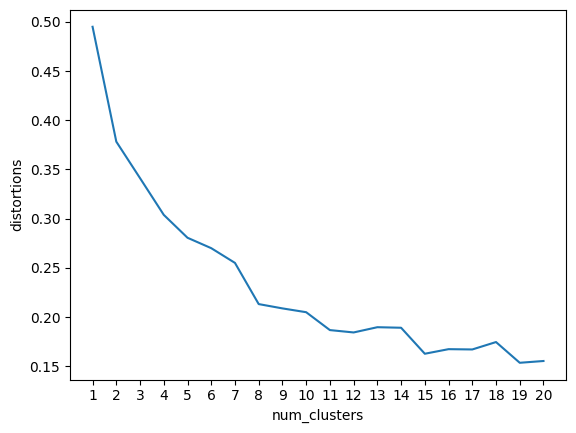

1

In [214]:
elbow_plot(tfidf_matrix_fixed)

In [261]:
num_clusters_fixed = 8

km_fixed, frame_fixed = create_clusters(tfidf_matrix_fixed, num_clusters_fixed, key_program_list, program_list)
program_cluster_df = print_clusters(km_fixed, frame_fixed, terms_fixed, num_clusters_fixed)
program_cluster_df

CPU times: user 136 ms, sys: 103 ms, total: 239 ms
Wall time: 56.8 ms
4    219
0     96
5     38
2     36
6     35
1     30
3     21
7      6
Name: cluster, dtype: int64
Top terms per cluster:

Cluster 0 words:
cultmass - 0.596
sport - 0.050
infrastructure - 0.023
informing - 0.022
partners - 0.019
education - 0.014
grants - 0.012
rights - 0.006

Cluster 0 keys:
1_Левин_Андрей,		1_Кириллова_Полина,		1_Кузнецова_Алёна,		1_Удимов_Даниил_Алексеевич,		1_Штейников_Юрий_Николаевич,		1_Миценко_Вадим_Валериевич,		2_Власов_Артем_Андреевич,		2_Сафина_Диана_Ураловна,		2_Антонов_Сергей_Валентинович,		2_Попов_Леонид_Андреевич,		2_Акушевич_Андрей_Дмитриевич,		2_Дьяков_Павел_Александрович,		2_Абдуллаева_Эмилия_Табриз_кызы,		3_Тюрина_Татьяна_Игоревна,		3_Чистяков_Михаил_Сергеевич,		3_Савченко_Анастасия_Игоревна,		3_Борисов_Василий_Александрович,		3_Хамматова_Гульназ_Марселевна,		3_Куркотов_Вадим_Александрович,		3_Антонов_Сергей_Валентинович,		3_Попов_Леонид_Андреевич,		3_Тен_Анна_Бенхиевна,		3_Самонов

/var/folders/zh/mnvg84rj3_7413ycjzpn5y8r0000gp/T/ipykernel_36511/194810076.py:23: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  cluster_dict[key] = [i, [ terms[order_centroids[i, 0]], 'fuzzy'][km.cluster_centers_[i][order_centroids[i, 0]] < 0.4 ] ]


,cluster,1
1_Левин_Андрей,0,cultmass
1_Кириллова_Полина,0,cultmass
1_Кузнецова_Алёна,0,cultmass
1_Удимов_Даниил_Алексеевич,0,cultmass
1_Штейников_Юрий_Николаевич,0,cultmass
...,...,...
3_Митькина_Мария_Александровна,7,education
4_Морозов_Сергей_Сергеевич,7,education
5_Морозов_Сергей_Сергеевич,7,education
6_Нагорных_Яна_Валерьевна,7,education


In [264]:
program_cluster_df_2 = program_cluster_df.reset_index()\
                .rename(columns={'index':'conv_x_name', 1:'program_cluster'})[['conv_x_name','program_cluster']]
program_cluster_df_2

,conv_x_name,program_cluster
0,1_Левин_Андрей,cultmass
1,1_Кириллова_Полина,cultmass
2,1_Кузнецова_Алёна,cultmass
3,1_Удимов_Даниил_Алексеевич,cultmass
4,1_Штейников_Юрий_Николаевич,cultmass
...,...,...
476,3_Митькина_Мария_Александровна,education
477,4_Морозов_Сергей_Сергеевич,education
478,5_Морозов_Сергей_Сергеевич,education
479,6_Нагорных_Яна_Валерьевна,education


In [265]:
program_cluster_df_2.groupby(['program_cluster']).size()

program_cluster
cultmass          126
education          44
fuzzy             219
grants             21
infrastructure     36
rights             35
dtype: int64

In [266]:
program_cluster_df_2.to_csv('program_clusters.csv', sep='\t', encoding='utf-8', index=False)


In [ ]:
'''

So we have the following clusters of programs:

- fuzzy
- cultmass
- education 
- infrastructure 
- rights 
- grants

'''

# 5. Visualizing 

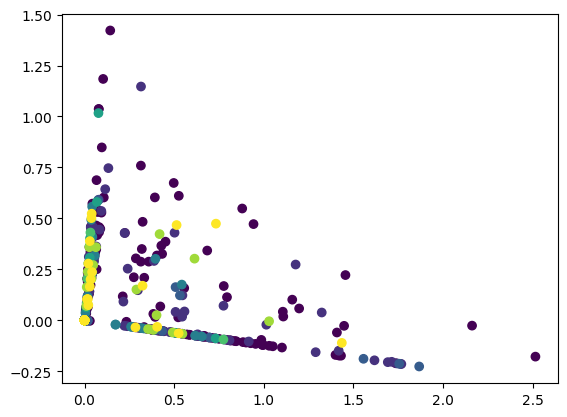

In [220]:
from sklearn.decomposition import PCA, TruncatedSVD

pca = TruncatedSVD(n_components=8).fit(tfidf_matrix_fixed)
# pca = PCA(n_components=8).fit(tfidf_matrix_fixed)
data2D = pca.transform(tfidf_matrix_fixed)
plt.scatter(data2D[:,0], data2D[:,1], c=program_cluster_df.cluster)
plt.show()

In [ ]:
'''
IDEAS:
    - to cluster programs:
        - for 1st nomination and for 2+ nominations (+, but no sense)
        - for clusters of persons !!!
        - only for 3+ time nominated persons
    - to unite text of each person with 2+ time nominated persons?
'''